## Análisis del Problema

Uno de los principales retos que ha encontrado la humanidad de la era moderna, ha sido la lucha contra el cáncer. Solo en el 2012, se le atribuyeron 8.2 millones de muertes a nivel mundial. Los cánceres que causan más muertes son los de pulmón, hígado, estómago, colon y mama. (Fuente: http://www.who.int/cancer/about/facts/es/)

El cáncer de mama se da principalmente en las mujeres, sin embargo también puede darse en los hombres. Como con los otros tipos de cáncer, no se conoce cómo o por qué se desarrolla, a pesar de que se conocen varios factores generales de riesgo (índice de masa corporal elevado, consumo insuficiente de frutas y erduras, falta de actividad física y consumo de tabaco y alcohol.)

A través de los años se han trabajado diferentes enfoques en la lucha contra el cáncer, no de ellos es el de detección temprana. Este enfoque busca detectar los síntomas de la enfermedad apenas están comenzando a desarrollarse, para determinar cómo puede evolucionar y así determinar el mejor tratamiento para el o la paciente.

Sobre esta línea, al detectarse los primeros tumores o masas en el cuerpo de un paciente, una de las principales decisiones es determinar si es un tumor benigno o maligno. Como parte de los esfuerzos para entender mejor esta enfermedad, se realizó un estudio de varias características del núcleo de las células en tumores extraídos de pacientes femeninas en Estados Unidos. El propósito de dicho estudio es tratar de predecir, o clasificar automáticamente si un tumor es benigno o maligno basado en dichas carácterísticas del núcleo de sus células.



## Entendimiento de los Datos

Como parte del estudio, se recolectaron los siguientes datos:

- Sample.number: número de muestra; números enteros entre 61634 y 13454352.
- Thickness: grosor de la masa; números enteros entre 1 y 10.
- Uniformity.Size: uniformidad del tamaño de la célula; números enteros entre 1 y 10.
- Uniformity.Shape: uniformidad de la forma de la célula; números enteros entre 1 y 10.
- Adhesion: adhesión marginal; números enteros entre 1 y 10.
- Epithelial.Size: tamaño de la célula epitelial; números enteros entre 1 y 10.
- Nuclei: nucleo de la célula; números enteros entre 1 y 10.
- Chromatin: cromatina blanda; números enteros entre 1 y 10.
- Nucleoli: "nucleoli" normal; números enteros entre 1 y 10.
- Mitoses: mitosis; números enteros entre 1 y 10.
- Class: clase de tumor; 2 para benigno y 4 para maligno.

In [2]:
system("pip3 install kb-python")
system("wget https://github.com/pachterlab/kallisto/releases/download/v0.46.1/kallisto_linux-v0.46.1.tar.gz")
untar("kallisto_linux-v0.46.1.tar.gz")
system("cp kallisto/kallisto /usr/local/bin")

In [4]:
install.packages("caTools")
install.packages("rpart")
install.packages("rpart.plot")
install.packages("ROCR")
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gplots’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
#Evitar mostrar warning messages
options(warn=-1)

#librerías utiliadas (puede que necesiten instalar una o más de estas librerías, en ese caso, utilicen install.packages)
library(caTools)
library(rpart)
library(rpart.plot)
library(ROCR)
library(dplyr)

#cargue el archivo a una variable que se llame bcw usando la función read.csv
#usen el parámetro col.names para pasarle un vector con los nombres de las columnas.
#nombres para las columnas: Sample.number, Thickness, Uniformity.Size, Uniformity.Shape, Adhesion, Epithelial.Size, Nuclei, Chromatin, Nucleoli, Mitoses, Class
#ejemplo: col.names = c('nombre1', 'nombre2')
#usen el parámetro na.strings = '?' para que interprete los signos de pregunta como valores faltantes
bcw <- read.csv('sample_data/bcw.csv', header = F, col.names = c('Sample.number', 'Thickness', 'Uniformity.Size', 'Uniformity.Shape', 'Adhesion', 'Epithelial.Size', 'Nuclei', 'Chromatin', 'Nucleoli', 'Mitoses', 'Class'), na.strings = '?')



Luego de cargar los datos, podemos dar un primer vistazo a cómo están estructurados:

In [10]:
#sobreescriban la columna Class con el factor de esa columna
bcw$Class <- factor(bcw$Class)

#Utilice la función str() para ver la estructura del conjunto de datos:
str(bcw)

'data.frame':	699 obs. of  11 variables:
 $ Sample.number   : int  1000025 1002945 1015425 1016277 1017023 1017122 1018099 1018561 1033078 1033078 ...
 $ Thickness       : int  5 5 3 6 4 8 1 2 2 4 ...
 $ Uniformity.Size : int  1 4 1 8 1 10 1 1 1 2 ...
 $ Uniformity.Shape: int  1 4 1 8 1 10 1 2 1 1 ...
 $ Adhesion        : int  1 5 1 1 3 8 1 1 1 1 ...
 $ Epithelial.Size : int  2 7 2 3 2 7 2 2 2 2 ...
 $ Nuclei          : int  1 10 2 4 1 10 10 1 1 1 ...
 $ Chromatin       : int  3 3 3 3 3 9 3 3 1 2 ...
 $ Nucleoli        : int  1 2 1 7 1 7 1 1 1 1 ...
 $ Mitoses         : int  1 1 1 1 1 1 1 1 5 1 ...
 $ Class           : Factor w/ 2 levels "2","4": 1 1 1 1 1 2 1 1 1 1 ...


En total, el conjunto de datos con el cual se va a trabajar tiene 699 observaciones, de las cuales 458 son tumores benignos (clase = 2) y 241 son malignos (clase = 4), para una proporción de 65.5% benignos y 34.5% malignos.


* Distribución de los datos obtenidos


  2   4 
458 241 

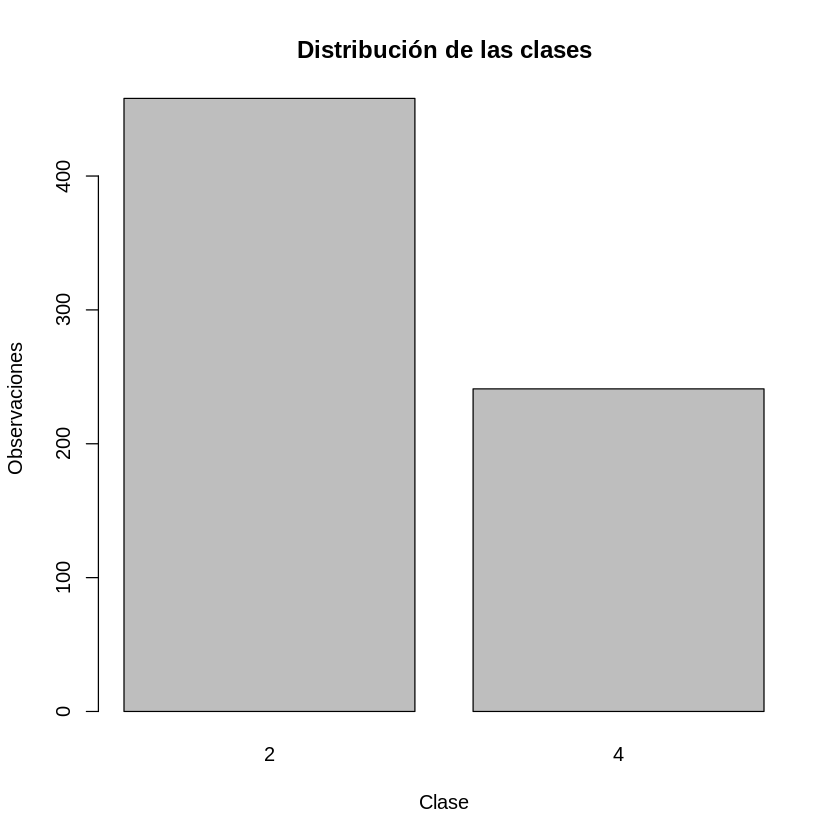

In [11]:
#utilicen la función table() para generar un resumen de las observaciones en bcw por la variable clase. Deberían ver 458 valores con clase = 2 y 241 con clase = 4
table(bcw$Class)

#utilicen la tabla generada en el paso anterior para generar un gráfico de barras usando la función barplot(). Recuerden incluir los parámetros main, xlab y ylab para agregar el título y las etiquetas.
barplot(table(bcw$Class), main = 'Distribución de las clases', ylab = 'Observaciones', xlab = 'Clase')

Para poder entrenar un modelo de minería de datos, necesitamos dividir el conjunto de datos original en dos diferentes: uno de entrenamiento, con el 70% de las observaciones, y uno de prueba con el restante 30%.

In [12]:
#usen la función set.seed para establecer la semilla con el valor 4161
set.seed(4161)

#las siguientes líneas de código van a crear un vector de valores lógicos
#este vector lo vamos a utilizar para dividir nuestro conjunto de datos original
#en dos: uno de entrenamiento para nuestro modelo y uno de prueba.
#la división se va a hacer con respecto a la columna Class, y vamos a
#dejar 70% de las  observaciones en el de entrenamiento y 30% en el de prueba.

#paso 1: crear el vector lógico
splt <- sample.split(bcw$Class, SplitRatio = 0.7)

#paso 2: crear el data frame de entrenamiento usando los valores TRUE del vector splt
bcw.entrenamiento <- bcw[splt,] #solo las observaciones para las cuales el vector splt es verdadero, y todas las columnas.

#paso 3: crear el data frame de prueba negando los valores de splt, para usar las observaciones que en el paso anterior eran falsas
bcw.prueba <- bcw[!splt,]

Luego de hacer la división, podemos confirmar que no perdimos información y que mantuvimos la proporción del conjunto de datos original:

In [13]:
#Utilicen la función nrow() para demostrar que en total seguimos trabajando con 699 registros aunque ahora tengamos 2 datasets.
nrow(bcw.entrenamiento) + nrow(bcw.prueba)

table(bcw.entrenamiento$Class)

table(bcw.prueba$Class)

[1] 699


  2   4 
321 169 


  2   4 
137  72 

El conjunto de datos de entrenamiento tiene 321 tumores benignos y 169 malignos (65.5% - 34.5%), y el conjunto de datos de prueba tiene 137 tumores benignos y 72 malignos (65.5% - 34.5%), para un total de 699 observaciones entre ambos).


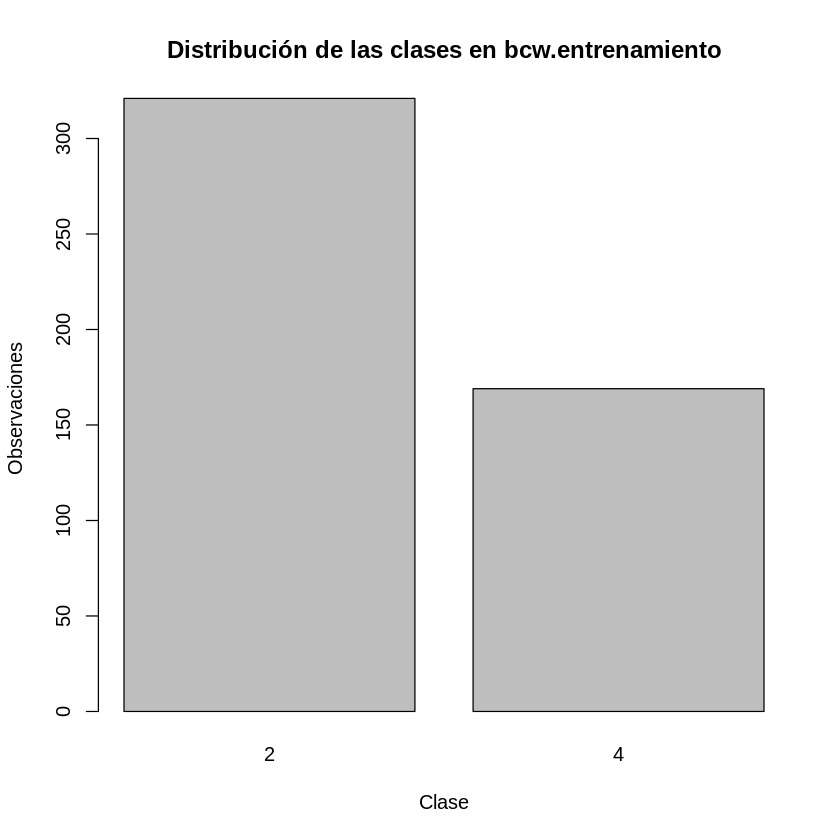

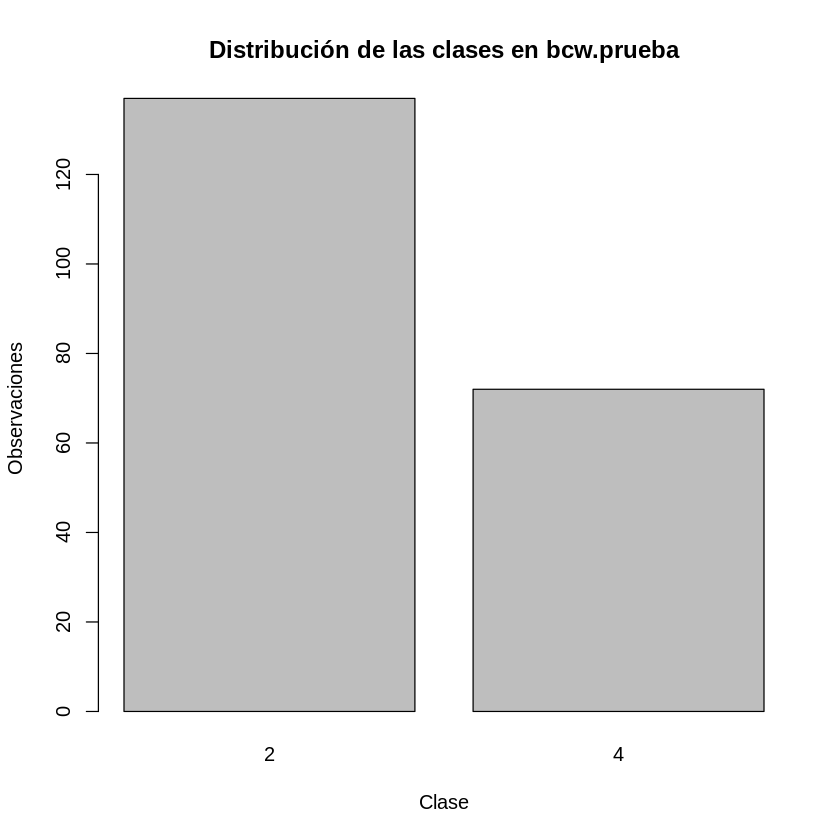

In [14]:
#Creen dos gráficos de barra usando barplot(), uno sobre bcw.entrenamiento y otro bcw.prueba para demostrar que se mantiene (o es similar) la proporción de clase = 2 y clase = 4 en los 2 datasets.

barplot(table(bcw.entrenamiento$Class), main = 'Distribución de las clases en bcw.entrenamiento', ylab = 'Observaciones', xlab = 'Clase')

barplot(table(bcw.prueba$Class), main = 'Distribución de las clases en bcw.prueba', ylab = 'Observaciones', xlab = 'Clase')


## Modelo de Minería de Datos

A partir de los conjuntos de datos de prueba y entrenamiento, vamos a crear un modelo de minería de datos que utilice un árbol de decisión para clasificar observaciones una de las dos clases: 2 (benigno) o 4 (maligno).

Primero, utilizamos el conjunto de datos de entrenamiento para crear el modelo:

In [15]:
#crear el modelo (esto lo veremos en detalle luego, pero debería haber algunas partes de la sintaxis que ya entiendan)
modelo.arbol <- rpart(Class ~ ., data = bcw.entrenamiento[,-which(colnames(bcw.entrenamiento) == "Sample.number")], method =  'class')

Una vez creado el modelo, procedemos a hacer las predicciones de las classes en nuestro conjunto de datos de prueba, y almacenamos dichas predicciones en un vector llamado "predicciones".

,2,4
2,0.08187135,0.91812865
3,0.98996656,0.01003344
6,0.08187135,0.91812865
7,0.98996656,0.01003344
10,0.98996656,0.01003344
11,0.98996656,0.01003344
13,0.08187135,0.91812865
14,0.98996656,0.01003344
15,0.08187135,0.91812865
18,0.98996656,0.01003344


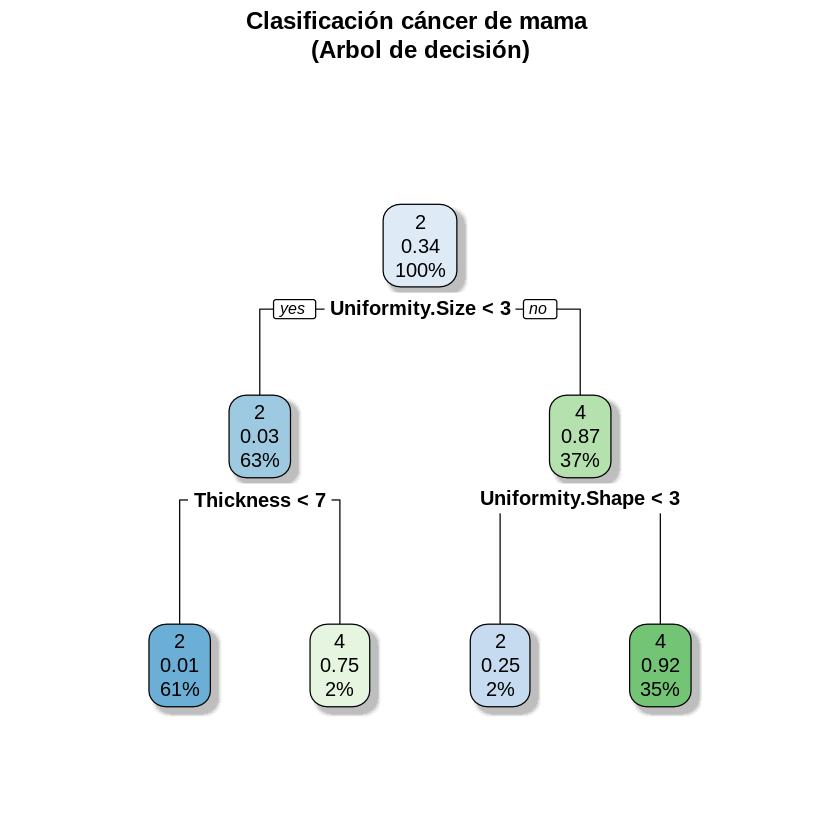

In [16]:
#predecir utilizando el conjunto de datos de prueba
predicciones <- predict(modelo.arbol, newdata = bcw.prueba, type = 'prob')
predicciones
rpart.plot(modelo.arbol,
           shadow.col = "gray", #Agregar sombras
           main = "Clasificación cáncer de mama \n(Arbol de decisión)\n")

## Evaluación

Para evaluar la eficacion del modelo de minería de datos, podemos tabular las predicciones (columnas) con los valores reales del conjunto de prueba (hileras):

*Notas Importantes*:

![Proceso ROC](https://i.ibb.co/QHhTvHn/matriz-de-confusi-n.png)

In [17]:
#Utilicen la función table() para comparar el resultado de las predicciones con el valor de la columna Class en el conjunto de datos de prueba
#ejemplo: table(vector1, vector2)
#el resultado les va a decir cuántas observaciones eran realmente 2 y fueron clasificadas como 2, y cuántas eran 4 y fueron clasificadas como 4
#también les va a decir cuántas eran 2 y fueron clasificadas como 4, y cuáles eran 4 y fueron clasificadas como 2

predicciones <- predict(modelo.arbol, newdata = bcw.prueba, type = 'class')

data<-table(bcw.prueba$Class, predicciones)
print(data)

   predicciones
      2   4
  2 128   9
  4   4  68


En general, podemos sacar las siguientes métricas a partir de la tabulación anterior:

\begin{equation}Exactitud=\frac{VP+VN}{Total}\end{equation}

- *Exactitud Total* (observaciones clasificadas apropiadamente) = 93.78% (128 benignos y 68 malignos clasificados correctamente).

In [18]:
print((data[1,1]+data[2,2]) / sum(data) )

[1] 0.937799


\begin{equation}\text{Sensibilidad}=\frac{VP}{\text{Total Positivos}}\end{equation}
- *Sensibilidad* (procentaje de positivos verdaderos - de las observaciones que realmente son benignas, ¿cuántas clasificó apropiadamente el modelo?) = 93.42% (de las 137 observaciones que son benignos, 128 fueron correctamente identificadas).

In [19]:
print( data[1,1] /(data[1,1]+data[1,2]))

[1] 0.9343066


\begin{equation}\text{Precisión}=\frac{VP}{\text{Total clasificados positivos}}\end{equation}
- *Precisión* (de las observaciones que el modelo determinó que eran benignas, ¿cuántas realmente eran benignas?) = 96.97% (de las 132 observaciones que fueron clasificadas como clase 2, 128 sí eran de esa clase).

In [20]:
print(data[1,1] /(data[1,1]+data[2,1] ))

[1] 0.969697


\begin{equation}\text{Especificidad}=\frac{VN}{\text{Total Negativos}}\end{equation}
- *Especificidad* (porcentaje de negativos verdaderos - en este caso, de las observaciones que realmente son malignas, ¿cuántas clasificó apropiadamente el modelo?) = 94.44% (de las 72 observaciones que son malignas, 68 fueron correctamente identificadas).

In [21]:
print( data[2,2] /(data[1,2]+data[2,2]))

[1] 0.8831169


[1] 0.9393755

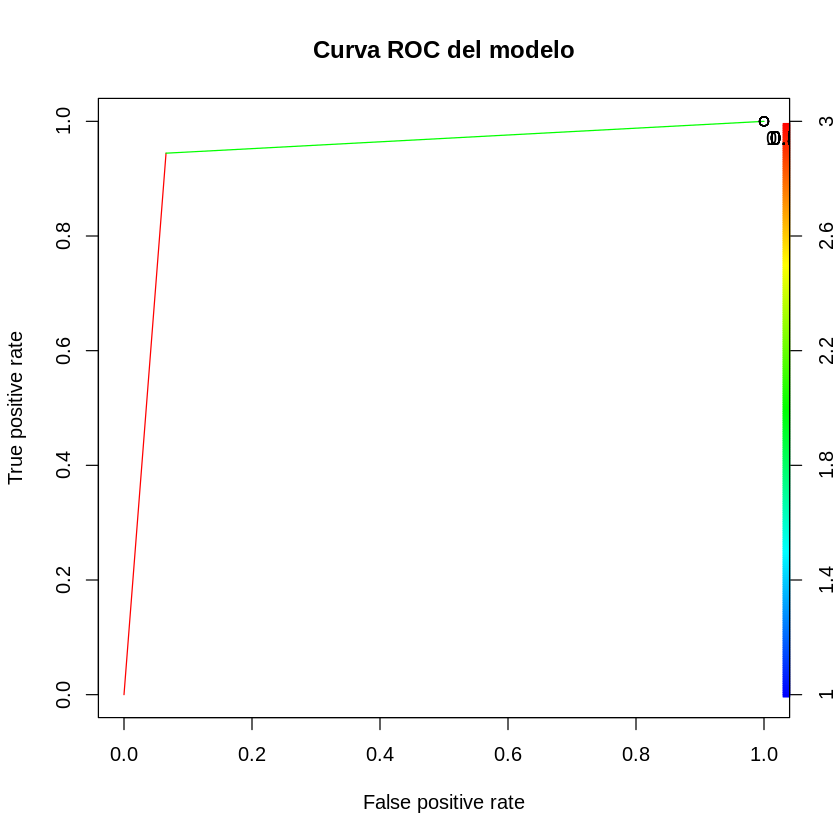

In [22]:
prediccionesROC=prediction(c(predicciones),c(bcw.prueba[,'Class']))
as.numeric(performance(prediccionesROC, "auc")@y.values)
plot(performance(prediccionesROC, "tpr", "fpr"),
colorize = T,
print.cutoffs.at=seq(0,1,by=0.1),
text.adj=c(-0.2,1.7),
main = 'Curva ROC del modelo')

*Proceso ROC*

![Proceso ROC](https://habrastorage.org/files/267/36b/ff1/26736bff158a4d82893ff85b2022cc5b.gif)

*Proceso ROC -2*

![Proceso ROC](https://i.stack.imgur.com/QY5BJ.png)

*Proceso ROC -3*

![Proceso ROC](https://i.stack.imgur.com/aVFCa.png)

## Resultados

En general, los resultados del modelo son considerablemente buenos, a pesar de ser un modelo relativamente sencillo. De las observaciones clasificadas, el 94% se hizo apropiadamente. 

Con respecto al tipo de decisiones que se pueden tomar en este caso, la decisión que puede ser más dañina para un paciente es que tenga un tumor maligno y erróneamente se diga que es benigno, pues el paciente podría no recibir tratamiento alguno y eventualmente fallecer. La *especificidad* del modelo es del 94.44%, así que podemos decir que el modelo solo tiene alrededor de un 5% de posibilidades de cometer este error. 

Alternativamente, se le podría decir al paciente que tiene un tumor maligno cuando en realidad el tumor es benigno. En este caso, el paciente podría pasar un mal rato emocionalmente y puede ser sujeto de más pruebas que eventualmente mostrarían la verdad. La *sensitividad* del modelo es del 93.42%, lo cual quiere decir que el modelo tiene cerca de un 7% probabilidad de cometer este error. Asimismo, la *precisión* es muy alta cerca del 97%, por lo que queda al criterio de los tomadores de decisiones usar o no este modelo.